## Exercícios
### 1 - Refaça o treino da árvore de decisão com validação cruzada.

Primeiramente importamos as bibliotecas necessárias:

In [10]:
from sklearn.metrics import classification_report , ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, cross_val_score


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Carregamos então o dataset e já realizamos o split para evitar data leakage

In [2]:
df = pd.read_csv('bank-full.csv')
y = df['Target'].copy()
X = df.drop('Target', axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42) 

Vamos então analisar os dados:

In [3]:
#Há nulos?
X_train.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

In [4]:
#como se organizam os dados?
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
13382,31,services,married,secondary,no,1,yes,no,cellular,9,jul,82,1,-1,0,unknown
32641,35,services,married,secondary,no,195,yes,no,cellular,17,apr,203,1,-1,0,unknown
3991,24,blue-collar,single,secondary,no,77,yes,no,unknown,16,may,236,2,-1,0,unknown
8068,35,blue-collar,married,secondary,no,80,yes,yes,unknown,2,jun,579,2,-1,0,unknown
27484,37,services,single,secondary,no,105,no,yes,cellular,21,nov,197,2,157,4,failure


In [5]:
#Analisando os resultados do target
y_train.value_counts(normalize=True)

no     0.883022
yes    0.116978
Name: Target, dtype: float64

Vamos manter apenas as colunas 'marital', 'age', 'balance', 'duration', 'education', 'housing' 
e resetar o index do X_train e X_test

In [6]:
keep_columns = ['marital', 'age', 'balance', 'duration', 'education', 'housing']
X_train = X_train[keep_columns].copy()
#Separando as colunas numéricas e categóricas
colunas_numericas = list(X_train.select_dtypes(include='number').columns)
colunas_categoricas =  list(X_train.select_dtypes(exclude='number').columns)

Com o OneHotEncoder e LabelEncoder, vamos converter as colunas categóricas do treino em dummy:

In [7]:
ohe = OneHotEncoder(sparse=False)
le = LabelEncoder()

X_train_enc = ohe.fit_transform(X_train[colunas_categoricas])
y_train = le.fit_transform(y_train)
X_train_enc = pd.DataFrame(X_train_enc, columns=ohe.get_feature_names_out(colunas_categoricas))
X_train = X_train.reset_index(drop=True)
X_train = pd.concat([X_train[colunas_numericas], X_train_enc], axis=1)

Fazemos o mesmo processo com os dados de teste:

In [8]:
X_test = X_test[keep_columns].copy()
X_test = X_test.reset_index(drop=True)
X_test_enc = ohe.transform(X_test[colunas_categoricas])
y_test = le.transform(y_test)
X_test_enc = pd.DataFrame(X_test_enc, columns=ohe.get_feature_names_out(colunas_categoricas))
X_test = pd.concat([X_test[colunas_numericas], X_test_enc], axis=1)

Para fazer o cross-validation, primeiramente vamos fazer o processo manual para procurar os melhores parâmetros para a árvore:

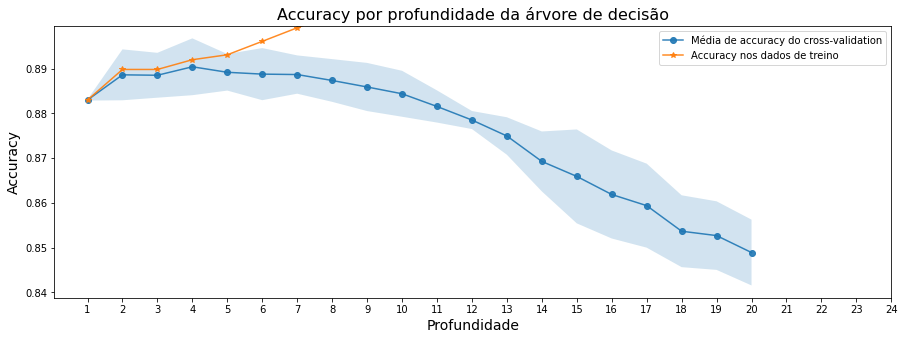

In [11]:
# Aplicando o cross validation em árvores de várias profundidades
scores_list = []
scores_std = []
scores_mean = []
accuracy_scores = []
for i in range(1,21):
    tree = DecisionTreeClassifier(max_depth=i)
    cv_scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')
    scores_list.append(cv_scores)
    scores_mean.append(cv_scores.mean())
    scores_std.append(cv_scores.std())
    accuracy_scores.append(tree.fit(X_train, y_train).score(X_train, y_train))
scores_mean = np.array(scores_mean)
scores_std = np.array(scores_std)
accuracy_scores = np.array(accuracy_scores)
  
# Plotando os resultados
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(range(1,21), scores_mean, '-o', label='Média de accuracy do cross-validation', alpha=0.9)
ax.fill_between(range(1,21), scores_mean-2*scores_std, scores_mean+2*scores_std, alpha=0.2)
ylim = plt.ylim()
ax.plot(range(1,21), accuracy_scores, '-*', label='Accuracy nos dados de treino', alpha=0.9)
ax.set_title('Accuracy por profundidade da árvore de decisão', fontsize=16)
ax.set_xlabel('Profundidade', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(ylim)
ax.set_xticks(range(1,21))
ax.legend()


Aparentemente a melhor seleção de profundidade para a árvore de decisão é de n=4, havendo claro overfit dos dados quando n=7. Vamos verificar isso pegando os valores máximos da média de accuracy:

In [12]:
idx_max = scores_mean.argmax()
best_tree_depth = range(1,21)[idx_max]
best_tree_cv_score = scores_mean[idx_max]
best_tree_cv_score_std = scores_std[idx_max]
print('A árvore de profundidade {} atinge a melhor média de accuracy, {} +/- {}% nos dados de treino'.format(
      best_tree_depth, round(best_tree_cv_score*100,5), round(best_tree_cv_score_std*100, 5)))

A árvore de profundidade 4 atinge a melhor média de accuracy, 89.04477 +/- 0.31787% nos dados de treino


Para facilitar o processo, podemos realizar o mesmo com o GridSearch, que irá buscar automaticamente pelos melhores parametros:

In [20]:
tree = DecisionTreeClassifier()
param = {'max_depth':range(1,21)}
tree_cv = GridSearchCV(tree,param,cv=5)
tree_cv.fit(X_train,y_train)
print('A árvore de profundidade {} atinge o melhor score, {} nos dados de treino'.format(tree_cv.best_params_, round(tree_cv.best_score_,3)))

A árvore de profundidade {'max_depth': 4} atinge o melhor score, 0.89 nos dados de treino


Sabendo quais os melhores parâmetros, podemos então avaliar o modelo nos dados de teste:

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11977
           1       0.56      0.23      0.33      1587

    accuracy                           0.89     13564
   macro avg       0.73      0.60      0.63     13564
weighted avg       0.87      0.89      0.87     13564



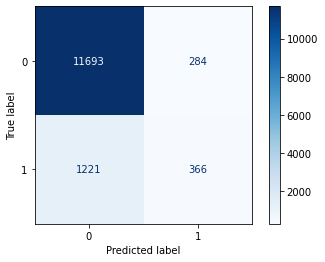

In [21]:
y_pred = tree_cv.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

#### Percebemos pela avaliação de nosso modelo que há uma boa previsão quanto às previsões negativas, com uma boa precisão para avaliação de verdadeiros negativos e baixos indices de falsos positivos. Entretanto, percebe-se uma quantidade alta de falsos negativos, com precisão relativamente baixa para dados positivos. Façamos então a mesma estimativa utilizando valores de folds diferentes no cross-validation:

Com número de folds = 2:

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11977
           1       0.56      0.23      0.33      1587

    accuracy                           0.89     13564
   macro avg       0.73      0.60      0.63     13564
weighted avg       0.87      0.89      0.87     13564



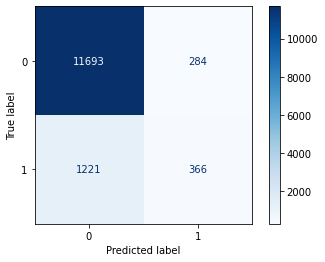

In [22]:
tree_cv_2 = GridSearchCV(tree,param,cv=2)
tree_cv_2.fit(X_train,y_train)
y_pred_2 = tree_cv.predict(X_test)
print(classification_report(y_test, y_pred_2))
cm_2 = confusion_matrix(y_test, y_pred_2)
ConfusionMatrixDisplay(cm_2).plot(cmap='Blues')
plt.show()

Percebe-se que não houve diferença. Tentemos novamente para k=10:

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11977
           1       0.56      0.23      0.33      1587

    accuracy                           0.89     13564
   macro avg       0.73      0.60      0.63     13564
weighted avg       0.87      0.89      0.87     13564



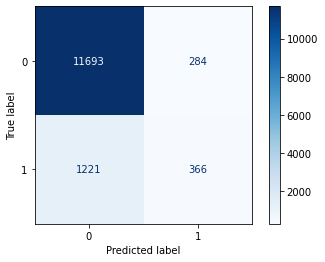

In [23]:
tree_cv_3 = GridSearchCV(tree,param,cv=10)
tree_cv_3.fit(X_train,y_train)
y_pred_3 = tree_cv.predict(X_test)
print(classification_report(y_test, y_pred_3))
cm_3 = confusion_matrix(y_test, y_pred_3)
ConfusionMatrixDisplay(cm_3).plot(cmap='Blues')
plt.show()

Ainda não houve diferenças, então sabemos que este é o valor final da estimativa. 

#### Façamos a classificação do mesmo problema utilizando outros métodos como KNN e logreg